# Load Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import shapiro
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, make_scorer, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_score
from joblib import dump, load
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import joblib

random_value = 10

np.random.seed(random_value)

# Prepare the data (as before)
file_path = 'diabetes.csv'
df = pd.read_csv(file_path)

# Replace zeros with NaN where applicable
df['BloodPressure'] = df['BloodPressure'].replace(0, np.nan)
df['SkinThickness'] = df['SkinThickness'].replace(0, np.nan)
df['Insulin'] = df['Insulin'].replace(0, np.nan)
df['BMI'] = df['BMI'].replace(0, np.nan)


print(df.info())

# Calculate the counts of each class (outcome -1 and 1)
outcome_counts = df['Outcome'].value_counts()

# Print outcome counts and class weights
print("Outcome Counts:", outcome_counts)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(5), int64(4)
memory usage: 54.1 KB
None
Outcome Counts: Outcome
0    500
1    268
Name: count, dtype: int64


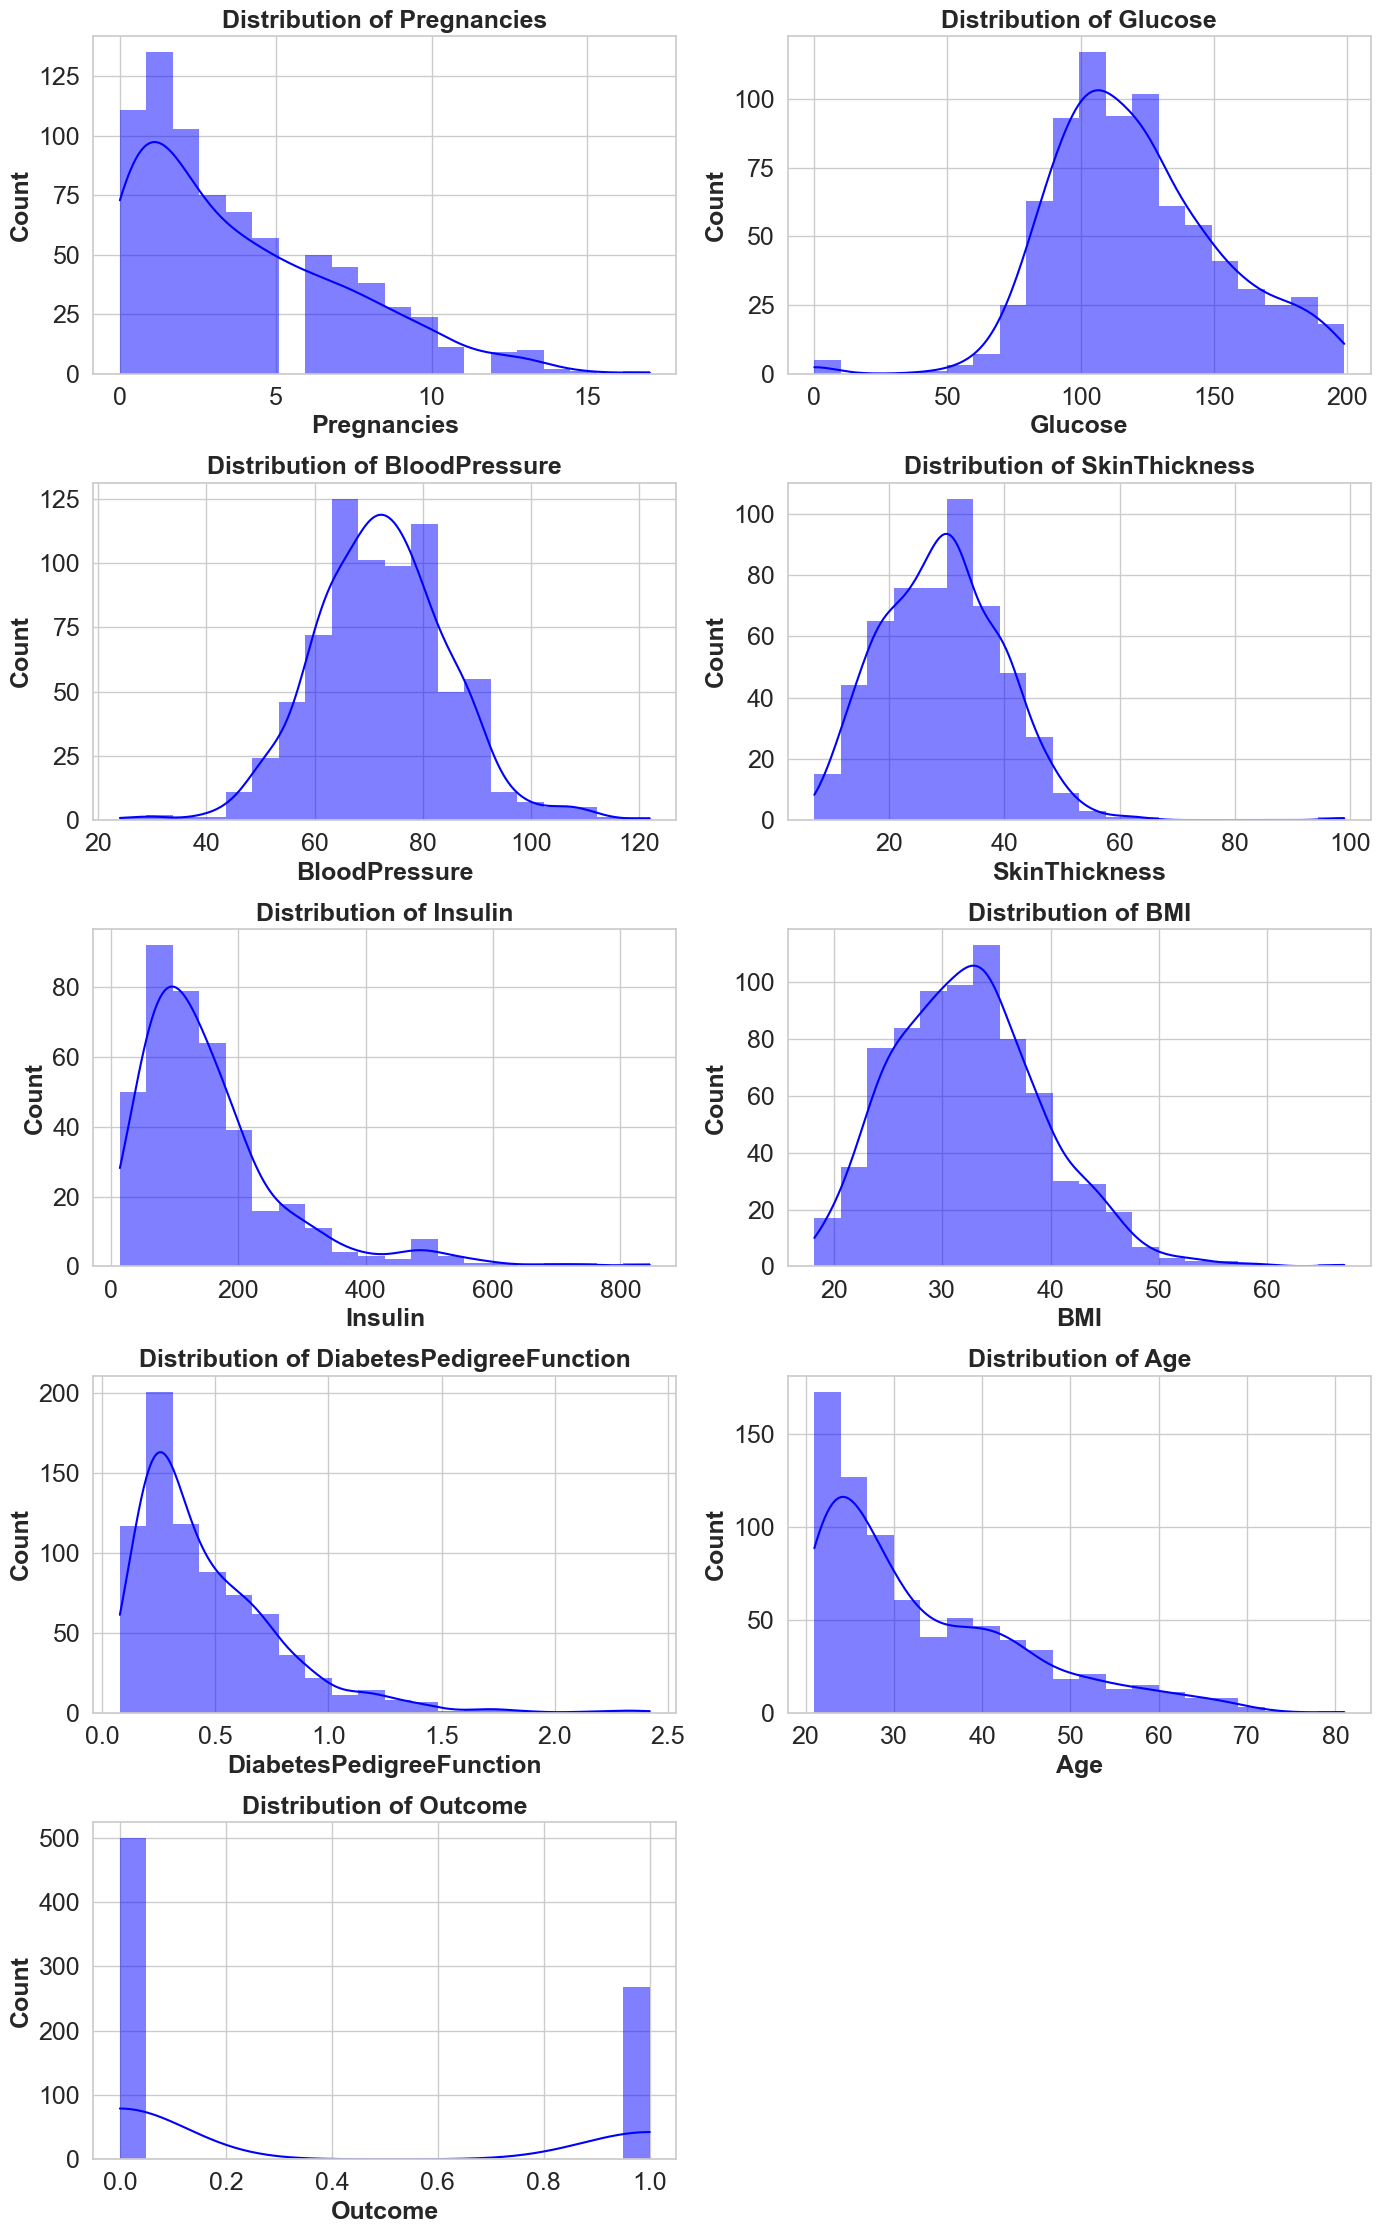

In [2]:
# Explore the Distribution

sns.set(style="whitegrid")

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

fig, axes = plt.subplots(len(numeric_columns) // 2 + len(numeric_columns) % 2, 2, figsize=(14, len(numeric_columns) * 2.5))

axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.histplot(df[column], bins=20, kde=True, color='blue', stat='count', linewidth=0, ax=axes[i])

    # Set titles and labels with bigger, bold fonts
    axes[i].set_title(f'Distribution of {column}', fontsize=18, weight='bold')
    axes[i].set_xlabel(column, fontsize=18, weight='bold')
    axes[i].set_ylabel('Count', fontsize=18, weight='bold')

    axes[i].tick_params(axis='both', which='major', labelsize=18)

if len(numeric_columns) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

In [3]:
# Normality Test
columns_to_test = df.columns[df.columns != 'Outcome']

for col in columns_to_test:
    data_col = df[col].dropna()
    
    stat, p_value = shapiro(data_col)
    print(f'{col} - Shapiro-Wilk Test Statistic: {stat:.4f}, p-value: {p_value:.4f}')
    
    if p_value > 0.05:
        print(f"The {col} column is normally distributed (p-value = {p_value:.4f})\n")
    else:
        print(f"The {col} column is NOT normally distributed (p-value = {p_value:.4f})\n")

Pregnancies - Shapiro-Wilk Test Statistic: 0.9043, p-value: 0.0000
The Pregnancies column is NOT normally distributed (p-value = 0.0000)

Glucose - Shapiro-Wilk Test Statistic: 0.9701, p-value: 0.0000
The Glucose column is NOT normally distributed (p-value = 0.0000)

BloodPressure - Shapiro-Wilk Test Statistic: 0.9903, p-value: 0.0001
The BloodPressure column is NOT normally distributed (p-value = 0.0001)

SkinThickness - Shapiro-Wilk Test Statistic: 0.9680, p-value: 0.0000
The SkinThickness column is NOT normally distributed (p-value = 0.0000)

Insulin - Shapiro-Wilk Test Statistic: 0.8041, p-value: 0.0000
The Insulin column is NOT normally distributed (p-value = 0.0000)

BMI - Shapiro-Wilk Test Statistic: 0.9796, p-value: 0.0000
The BMI column is NOT normally distributed (p-value = 0.0000)

DiabetesPedigreeFunction - Shapiro-Wilk Test Statistic: 0.8365, p-value: 0.0000
The DiabetesPedigreeFunction column is NOT normally distributed (p-value = 0.0000)

Age - Shapiro-Wilk Test Statisti

In [4]:
# Split into Train Set and Test Set
X = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']].values
y = df['Outcome'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=random_value)

# Common Function

In [5]:
# Custom function to calculate specificity
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

# Create a custom scorer for specificity
specificity_scorer = make_scorer(specificity_score)

# Create a directory to save the models
if not os.path.exists('models'):
    os.makedirs('models')

if not os.path.exists('results'):
    os.makedirs('results')

# Perceptron Model

In [6]:
class BasePerceptron(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, n_epochs=1000, penalty=None, 
                 penalty_strength=0.01, elasticnet_ratio=0.5, init_type='normal', init_scale=0.01):
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.penalty = penalty  # Regularization: None, 'l1', 'l2', 'elasticnet'
        self.penalty_strength = penalty_strength  # Regularization strength
        self.elasticnet_ratio = elasticnet_ratio  # Ratio between L1 and L2 penalties
        self.init_type = init_type
        self.init_scale = init_scale
        self.weights = None
        self.bias = None
        self.classes_ = None

    def activation_function(self, x):
        """Step function that returns 1 if x >= 0, else 0."""
        return np.where(x >= 0, 1, 0)

    def initialize_weights(self, n_features):
        """Initialize weights based on the specified method."""
        rgen = np.random.RandomState(random_value)  # Ensure random_value is defined or passed
        if self.init_type == 'normal':
            self.weights = rgen.normal(0, self.init_scale, n_features)
        elif self.init_type == 'uniform':
            self.weights = rgen.uniform(-self.init_scale, self.init_scale, n_features)
        elif self.init_type == 'zero':
            self.weights = np.zeros(n_features)
        else:
            raise ValueError(f"Unknown init_type: {self.init_type}")
        
        self.bias = 0  # Bias can be initialized to 0

    def compute_penalty_gradient(self):
        """Compute the penalty gradient based on the specified regularization."""
        if self.penalty == 'l2':
            penalty_gradient = self.penalty_strength * self.weights
        elif self.penalty == 'l1':
            penalty_gradient = self.penalty_strength * np.sign(self.weights)
        elif self.penalty == 'elasticnet':
            l1_component = self.elasticnet_ratio * np.sign(self.weights)
            l2_component = (1 - self.elasticnet_ratio) * self.weights
            penalty_gradient = self.penalty_strength * (l1_component + l2_component)
        else:
            penalty_gradient = 0
        return penalty_gradient

    def fit(self, X, y):
        """Training loop for the base perceptron model."""
        n_samples, n_features = X.shape
        self.initialize_weights(n_features)
        self.classes_ = np.unique(y)

        # Ensure the labels are 0 and 1
        y = np.where(y == self.classes_[0], 0, 1)

        # Training loop
        for _ in range(self.n_epochs):
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_pred = self.activation_function(linear_output)

                # Compute the error
                error = y[idx] - y_pred

                # Update rule if there is a misclassification
                if error != 0:
                    # Compute penalty gradient
                    penalty_gradient = self.compute_penalty_gradient()

                    # Update weights and bias
                    self.weights += self.learning_rate * (error * x_i - penalty_gradient)
                    self.bias += self.learning_rate * error

    def predict(self, X):
        """Make predictions for the given input X."""
        linear_output = np.dot(X, self.weights) + self.bias
        preds = self.activation_function(linear_output)
        return np.where(preds == 0, self.classes_[0], self.classes_[1])


## Baseline

Processing pipeline: BasePerceptron
Best model saved to models/BasePerceptron_baseline.joblib
Results saved to results/BasePerceptron_baseline_results.csv

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.62      0.70       424
           1       0.50      0.71      0.59       228

    accuracy                           0.65       652
   macro avg       0.65      0.67      0.64       652
weighted avg       0.70      0.65      0.66       652



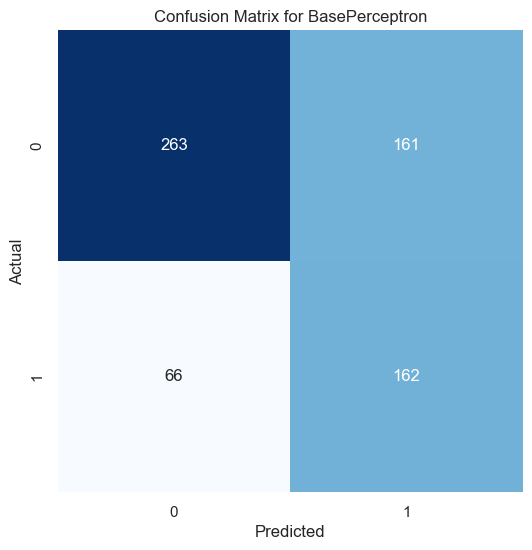

Processing complete for all pipelines.


,mean_test_accuracy,std_test_accuracy,mean_test_specificity,std_test_specificity,mean_test_sensitivity,std_test_sensitivity,mean_test_f1,std_test_f1,mean_test_balanced_accuracy,std_test_balanced_accuracy
0,0.650476,0.054108,0.653389,0.10218,0.645024,0.19416,0.552247,0.099958,0.649207,0.072723


In [146]:
np.random.seed(random_value)

pipelines = {
    'BasePerceptron': Pipeline([
        ('imputer', IterativeImputer(random_state=random_value)),  
        ('scaler', RobustScaler()),
        ('classifier', BasePerceptron())
    ])
}

for pipeline_name, pipeline in pipelines.items():
    print(f"Processing pipeline: {pipeline_name}")
    
    scoring = {
        'accuracy': 'accuracy',
        'specificity': specificity_scorer,
        'sensitivity': make_scorer(recall_score),  # Sensitivity = recall for the positive class
        'f1': 'f1',
        'balanced_accuracy': 'balanced_accuracy'
    }
    
    param_grid = {
        'classifier__learning_rate': [0.01],
        'classifier__penalty': [None],
        'classifier__n_epochs': [50],
        'classifier__init_type': ['normal'],
    }

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring,
        refit='balanced_accuracy',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_value),
        n_jobs=8,
        verbose=0
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    model_file = f'models/{pipeline_name}_baseline.joblib'
    dump(best_model, model_file)
    print(f"Best model saved to {model_file}")

    results_df = pd.DataFrame(grid_search.cv_results_)

    results_file = f'results/{pipeline_name}_baseline_results.csv'
    results_df.to_csv(results_file, index=False)
    print(f"Results saved to {results_file}")
    
    y_pred_cv = cross_val_predict(best_model, X_train, y_train, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_value))

    cm = confusion_matrix(y_train, y_pred_cv)

    # Display the confusion matrix and classification report
    #print(f"Confusion Matrix for {pipeline_name}:")
    #print(cm)

    print("\nClassification Report:")
    print(classification_report(y_train, y_pred_cv))


    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {pipeline_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("Processing complete for all pipelines.")

mean_std_df = results_df.filter(regex='mean_test_|std_test_')
mean_std_df


### Optimizing Perceptron Model (Without Penalty)

In [147]:
np.random.seed(random_value)

pipelines = {
    'BasePerceptron': Pipeline([
        ('imputer', IterativeImputer(random_state=random_value)),  
        ('scaler', RobustScaler()),
        ('classifier', BasePerceptron())
    ])
}

for pipeline_name, pipeline in pipelines.items():
    print(f"Processing pipeline: {pipeline_name}")
    scoring = {
            'accuracy': 'accuracy',
            'specificity': specificity_scorer,
            'sensitivity': make_scorer(recall_score),  
            'f1': 'f1',
            'balanced_accuracy': 'balanced_accuracy'
    }   
    param_grid = {
            'classifier__learning_rate': [1.0, 0.5, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001],
            'classifier__penalty': [None],
            'classifier__n_epochs': [50,100,150],
            'classifier__init_type': ['zero','normal', 'uniform'],
            'classifier__penalty': [None],
    }       

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring,
        refit='balanced_accuracy',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_value),
        n_jobs=8, 
        verbose=0
    )

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Save the best model
    best_model = grid_search.best_estimator_
    model_file = f'models/{pipeline_name}__wo_penalty.joblib'
    dump(best_model, model_file)
    print(f"Best model saved to {model_file}")

    # Get the results from the grid search
    results_df = pd.DataFrame(grid_search.cv_results_)
    
    # Save the results to CSV
    results_file = f'results/{pipeline_name}_wo_penalty.csv'
    results_df.to_csv(results_file, index=False)
    print(f"Results saved to {results_file}")

    print("Processing complete for all pipelines.")

Processing pipeline: BasePerceptron
Best model saved to models/BasePerceptron__wo_penalty.joblib
Results saved to results/BasePerceptron_wo_penalty.csv
Processing complete for all pipelines.


In [38]:
results_file = 'results/BasePerceptron_wo_penalty.csv'
results_df = pd.read_csv(results_file)

mean_std_df = results_df.filter(regex='mean_test_|std_test_|param_')

top_5_results = mean_std_df.sort_values(by='mean_test_balanced_accuracy', ascending=False).head(5)

print("Top 5 Results sorted by balanced accuracy:")
(top_5_results)


Top 5 Results sorted by balanced accuracy:


,param_classifier__init_type,param_classifier__learning_rate,param_classifier__n_epochs,param_classifier__penalty,mean_test_accuracy,std_test_accuracy,mean_test_specificity,std_test_specificity,mean_test_sensitivity,std_test_sensitivity,mean_test_f1,std_test_f1,mean_test_balanced_accuracy,std_test_balanced_accuracy
51,uniform,0.500,50,NaN,0.685790,0.063241,0.684090,0.088719,0.688213,0.095726,0.605247,0.067197,0.686151,0.061133
40,normal,0.010,100,NaN,0.673447,0.054492,0.660084,0.128924,0.696425,0.152028,0.594092,0.057720,0.678255,0.048343
45,normal,0.001,50,NaN,0.661127,0.047497,0.643838,0.092261,0.691304,0.164794,0.580587,0.078931,0.667571,0.061337
57,uniform,0.100,50,NaN,0.661069,0.053673,0.648515,0.068719,0.683382,0.158544,0.578720,0.088841,0.665949,0.071042
42,normal,0.005,50,NaN,0.662736,0.062570,0.655490,0.155701,0.674010,0.167999,0.577191,0.063753,0.664750,0.048451


In [39]:
results_file = 'results/BasePerceptron_wo_penalty.csv'
results_df = pd.read_csv(results_file)

mean_std_df = results_df.filter(regex='mean_test_|std_test_|param_')

top_5_results = mean_std_df.sort_values(by='mean_test_accuracy', ascending=False).head(5)

print("Top 5 Results sorted by accuracy:")
(top_5_results)

Top 5 Results sorted by accuracy:


,param_classifier__init_type,param_classifier__learning_rate,param_classifier__n_epochs,param_classifier__penalty,mean_test_accuracy,std_test_accuracy,mean_test_specificity,std_test_specificity,mean_test_sensitivity,std_test_sensitivity,mean_test_f1,std_test_f1,mean_test_balanced_accuracy,std_test_balanced_accuracy
51,uniform,0.500,50,NaN,0.685790,0.063241,0.684090,0.088719,0.688213,0.095726,0.605247,0.067197,0.686151,0.061133
40,normal,0.010,100,NaN,0.673447,0.054492,0.660084,0.128924,0.696425,0.152028,0.594092,0.057720,0.678255,0.048343
64,uniform,0.010,100,NaN,0.667258,0.044842,0.674398,0.080941,0.652850,0.176745,0.569197,0.084772,0.663624,0.066144
71,uniform,0.001,150,NaN,0.667223,0.059698,0.686387,0.034812,0.630918,0.118707,0.567420,0.087598,0.658652,0.072632
38,normal,0.050,150,NaN,0.664181,0.059626,0.693389,0.124292,0.608406,0.192676,0.546066,0.104722,0.650898,0.069856


### Optimizing Perceptron Model (With Penalty)

In [47]:
np.random.seed(random_value)

pipelines = {
    'BasePerceptron': Pipeline([
        ('imputer', IterativeImputer(random_state=random_value)),  
        ('scaler', RobustScaler()),
        ('classifier', BasePerceptron())
    ])
}

for pipeline_name, pipeline in pipelines.items():
    print(f"Processing pipeline: {pipeline_name}")
    scoring = {
            'accuracy': 'accuracy',
            'specificity': specificity_scorer,
            'sensitivity': make_scorer(recall_score),
            'f1': 'f1',
            'balanced_accuracy': 'balanced_accuracy'
    }   
    param_grid = {
            'classifier__learning_rate': [1.0, 0.5, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001],
            'classifier__n_epochs': [50,100,150],
            'classifier__init_type': ['zero','normal', 'uniform'],
            'classifier__penalty': ['l1', 'l2', 'elasticnet'],
            'classifier__penalty_strength': [0.001, 0.01, 0.1],
    }       

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring,
        refit='balanced_accuracy',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_value),
        n_jobs=8,
        verbose=0
    )

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Save the best model
    best_model = grid_search.best_estimator_
    model_file = f'models/{pipeline_name}_penalty.joblib'
    dump(best_model, model_file)
    print(f"Best model saved to {model_file}")

    # Get the results from the grid search
    results_df = pd.DataFrame(grid_search.cv_results_)
    
    # Save the results to CSV
    results_file = f'results/{pipeline_name}_penalty.csv'
    results_df.to_csv(results_file, index=False)
    print(f"Results saved to {results_file}")

    print("Processing complete for all pipelines.")

Processing pipeline: BasePerceptron
Best model saved to models/BasePerceptron_penalty.joblib
Results saved to results/BasePerceptron_penalty.csv
Processing complete for all pipelines.


In [48]:
results_file = 'results/BasePerceptron_penalty.csv'
results_df = pd.read_csv(results_file)

# Select relevant columns (mean, std, and parameters)
mean_std_df = results_df.filter(regex='mean_test_|std_test_|param_')

# Sort by mean test balanced accuracy and show the top 5
top_5_results = mean_std_df.sort_values(by='mean_test_balanced_accuracy', ascending=False).head(5)

print("Top 5 Results sorted by balanced accuracy:")
(top_5_results)


Top 5 Results sorted by balanced accuracy:


,param_classifier__init_type,param_classifier__learning_rate,param_classifier__n_epochs,param_classifier__penalty,param_classifier__penalty_strength,mean_test_accuracy,std_test_accuracy,mean_test_specificity,std_test_specificity,mean_test_sensitivity,std_test_sensitivity,mean_test_f1,std_test_f1,mean_test_balanced_accuracy,std_test_balanced_accuracy
401,normal,0.005,150,l2,0.100,0.693341,0.045153,0.688739,0.082167,0.701256,0.105165,0.613464,0.053731,0.694998,0.045044
407,normal,0.001,50,l1,0.100,0.675091,0.079133,0.637003,0.127210,0.745121,0.083129,0.618995,0.063051,0.691062,0.064733
98,zero,0.100,100,elasticnet,0.100,0.665649,0.052004,0.615714,0.110824,0.759903,0.165033,0.608400,0.070481,0.687809,0.058296
619,uniform,0.005,150,elasticnet,0.010,0.665778,0.062638,0.618179,0.067811,0.754493,0.058522,0.613795,0.063289,0.686336,0.060826
291,normal,0.200,150,l2,0.001,0.665755,0.077751,0.622829,0.133300,0.745217,0.124269,0.609491,0.069463,0.684023,0.067124


In [49]:
results_file = 'results/BasePerceptron_penalty.csv'
results_df = pd.read_csv(results_file)

# Select relevant columns (mean, std, and parameters)
mean_std_df = results_df.filter(regex='mean_test_|std_test_|param_')

# Sort by mean test balanced accuracy and show the top 5
top_5_results = mean_std_df.sort_values(by='mean_test_accuracy', ascending=False).head(5)

print("Top 5 Results sorted by accuracy:")
(top_5_results)


Top 5 Results sorted by accuracy:


,param_classifier__init_type,param_classifier__learning_rate,param_classifier__n_epochs,param_classifier__penalty,param_classifier__penalty_strength,mean_test_accuracy,std_test_accuracy,mean_test_specificity,std_test_specificity,mean_test_sensitivity,std_test_sensitivity,mean_test_f1,std_test_f1,mean_test_balanced_accuracy,std_test_balanced_accuracy
401,normal,0.005,150,l2,0.10,0.693341,0.045153,0.688739,0.082167,0.701256,0.105165,0.613464,0.053731,0.694998,0.045044
397,normal,0.005,150,l1,0.01,0.691803,0.042561,0.764006,0.078224,0.555749,0.200319,0.537800,0.129605,0.659877,0.072888
403,normal,0.005,150,elasticnet,0.01,0.688867,0.064990,0.768683,0.133231,0.538068,0.217635,0.528237,0.128667,0.653376,0.078931
475,uniform,0.500,100,elasticnet,0.01,0.684204,0.073510,0.693389,0.152313,0.665507,0.139309,0.593876,0.066569,0.679448,0.056680
571,uniform,0.010,50,l2,0.01,0.684099,0.046114,0.754818,0.054499,0.551304,0.135510,0.542424,0.097621,0.653061,0.062218


# Sigmoid Model

In [7]:
class SigmoidModel(BasePerceptron):
    def __init__(self, learning_rate=0.01, n_epochs=1000, penalty=None, penalty_strength=0.01, elasticnet_ratio=0.5, 
                 init_type='normal', init_scale=0.01, shuffle=True, random_state=None):
        super().__init__(learning_rate, n_epochs, penalty, penalty_strength, elasticnet_ratio, init_type, init_scale)
        self.shuffle = shuffle
        self.random_state = random_state
        if random_state is not None:
            self.rgen = np.random.RandomState(self.random_state)
        else:
            self.rgen = np.random

    def activation_function(self, x):
        """Sigmoid activation function."""
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    
    def initialize_weights(self, n_features):
        """Initialize weights based on the specified method."""
        if self.init_type == 'normal':
            self.weights = self.rgen.normal(0, self.init_scale, n_features)
        elif self.init_type == 'uniform':
            self.weights = self.rgen.uniform(-self.init_scale, self.init_scale, n_features)
        elif self.init_type == 'zero':
            self.weights = np.zeros(n_features)
        else:
            raise ValueError(f"Unknown init_type: {self.init_type}")
        
        self.bias = 0

    def fit(self, X, y):
        """Training loop using Sigmoid activation and BCE loss, with optional shuffling."""
        n_samples, n_features = X.shape
        self.initialize_weights(n_features)
        self.classes_ = np.unique(y)

        # Ensure the labels are 0 and 1
        y = np.where(y == self.classes_[0], 0, 1)

        # Training loop
        for _ in range(self.n_epochs):
            # Shuffle the dataset at the start of each epoch if shuffle is enabled
            if self.shuffle:
                indices = np.arange(n_samples)
                self.rgen.shuffle(indices)
                X = X[indices]
                y = y[indices]
            
            # Iterate through each sample
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_pred = self.activation_function(linear_output)
                
                # Compute the error
                error = y_pred - y[idx]

                # Compute penalty gradient
                penalty_gradient = self.compute_penalty_gradient()

                # Update weights and bias
                self.weights -= self.learning_rate * (error * x_i + penalty_gradient)
                self.bias -= self.learning_rate * error

    def predict_proba(self, X):
        """Predict probabilities using the Sigmoid activation."""
        linear_output = np.dot(X, self.weights) + self.bias
        probas_class_1 = self.activation_function(linear_output)
        probas_class_0 = 1 - probas_class_1
        return np.vstack([probas_class_0, probas_class_1]).T
        
    def predict(self, X):
        """Make binary predictions based on the probability threshold of 0.5."""
        probas = self.predict_proba(X)
        return np.where(probas[:, 1] >= 0.5, self.classes_[1], self.classes_[0])


### Without Penalty

In [52]:
np.random.seed(random_value)

pipelines = {
    'SigmoidModel': Pipeline([
        ('imputer', IterativeImputer(random_state=random_value)),  
        ('scaler', RobustScaler()),
        ('classifier', SigmoidModel(random_state=random_value))
    ])
}

for pipeline_name, pipeline in pipelines.items():
    print(f"Processing pipeline: {pipeline_name}")
    scoring = {
            'accuracy': 'accuracy',
            'specificity': specificity_scorer,
            'sensitivity': make_scorer(recall_score), 
            'f1': 'f1',
            'roc_auc':'roc_auc',
            'balanced_accuracy': 'balanced_accuracy'
    }   
    param_grid = {
            'classifier__learning_rate': [1.0, 0.5, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001],
            'classifier__penalty': [None],
            'classifier__n_epochs': [50,100,150],
            'classifier__init_type': ['zero','normal', 'uniform'],
            'classifier__penalty': [None],
    }       

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring,
        refit='roc_auc',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_value),
        n_jobs=8,
        verbose=0
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    model_file = f'models/{pipeline_name}__wo_penalty.joblib'
    dump(best_model, model_file)
    print(f"Best model saved to {model_file}")

    results_df = pd.DataFrame(grid_search.cv_results_)
    
    results_file = f'results/{pipeline_name}_wo_penalty.csv'
    results_df.to_csv(results_file, index=False)
    print(f"Results saved to {results_file}")

    print("Processing complete for all pipelines.")

Processing pipeline: SigmoidModel
Best model saved to models/SigmoidModel__wo_penalty.joblib
Results saved to results/SigmoidModel_wo_penalty.csv
Processing complete for all pipelines.


In [53]:
results_file = 'results/SigmoidModel_wo_penalty.csv'
results_df = pd.read_csv(results_file)

# Select relevant columns (mean, std, and parameters)
mean_std_df = results_df.filter(regex='mean_test_|std_test_|param_')

# Sort by mean test balanced accuracy and show the top 5
top_5_results = mean_std_df.sort_values(by='mean_test_balanced_accuracy', ascending=False).head(5)

print("Top 5 Results sorted by balanced accuracy:")
(top_5_results)


Top 5 Results sorted by balanced accuracy:


,param_classifier__init_type,param_classifier__learning_rate,param_classifier__n_epochs,param_classifier__penalty,mean_test_accuracy,std_test_accuracy,mean_test_specificity,std_test_specificity,mean_test_sensitivity,std_test_sensitivity,mean_test_f1,std_test_f1,mean_test_roc_auc,std_test_roc_auc,mean_test_balanced_accuracy,std_test_balanced_accuracy
34,normal,0.10,100,NaN,0.753235,0.054915,0.811373,0.059840,0.645314,0.074804,0.647087,0.069826,0.825224,0.063361,0.728343,0.056351
31,normal,0.20,100,NaN,0.747070,0.050731,0.792521,0.055755,0.662995,0.082100,0.646807,0.066137,0.821158,0.064243,0.727758,0.054183
58,uniform,0.10,100,NaN,0.757769,0.041277,0.837255,0.030173,0.609469,0.120637,0.632432,0.080194,0.823014,0.057155,0.723362,0.057928
6,zero,0.20,50,NaN,0.754739,0.056651,0.832633,0.087720,0.609082,0.073097,0.635934,0.062608,0.815869,0.057532,0.720858,0.049976
12,zero,0.05,50,NaN,0.760846,0.041688,0.856162,0.048364,0.582899,0.075528,0.629344,0.061989,0.829284,0.058950,0.719531,0.045442


In [125]:
results_file = 'results/SigmoidModel_wo_penalty.csv'
results_df = pd.read_csv(results_file)

# Select relevant columns (mean, std, and parameters)
mean_std_df = results_df.filter(regex='mean_test_|std_test_|param_')

# Sort by mean test balanced accuracy and show the top 5
top_5_results = mean_std_df.sort_values(by='mean_test_accuracy', ascending=False).head(5)

print("Top 5 Results sorted by accuracy:")
(top_5_results)


Top 5 Results sorted by accuracy:


,param_classifier__init_type,param_classifier__learning_rate,param_classifier__n_epochs,param_classifier__penalty,mean_test_accuracy,std_test_accuracy,mean_test_specificity,std_test_specificity,mean_test_sensitivity,std_test_sensitivity,mean_test_f1,std_test_f1,mean_test_roc_auc,std_test_roc_auc,mean_test_balanced_accuracy,std_test_balanced_accuracy
60,uniform,0.050,50,NaN,0.763876,0.026488,0.875126,0.035896,0.556908,0.043061,0.622591,0.038786,0.830831,0.056963,0.716017,0.026798
12,zero,0.050,50,NaN,0.760846,0.041688,0.856162,0.048364,0.582899,0.075528,0.629344,0.061989,0.829284,0.058950,0.719531,0.045442
57,uniform,0.100,50,NaN,0.760787,0.019562,0.884566,0.046536,0.530918,0.104274,0.602922,0.060369,0.828440,0.053025,0.707742,0.034601
18,zero,0.005,50,NaN,0.759307,0.034737,0.872689,0.039521,0.548019,0.062822,0.613503,0.054872,0.828226,0.057906,0.710354,0.038036
10,zero,0.100,100,NaN,0.757780,0.041800,0.849048,0.060650,0.588309,0.150455,0.620400,0.092672,0.820346,0.059904,0.718678,0.061001


In [54]:
results_file = 'results/SigmoidModel_wo_penalty.csv'
results_df = pd.read_csv(results_file)

# Select relevant columns (mean, std, and parameters)
mean_std_df = results_df.filter(regex='mean_test_|std_test_|param_')

# Sort by mean test balanced accuracy and show the top 5
top_5_results = mean_std_df.sort_values(by='mean_test_roc_auc', ascending=False).head(5)

print("Top 5 Results sorted by ROC-AUC:")
(top_5_results)


Top 5 Results sorted by ROC-AUC:


,param_classifier__init_type,param_classifier__learning_rate,param_classifier__n_epochs,param_classifier__penalty,mean_test_accuracy,std_test_accuracy,mean_test_specificity,std_test_specificity,mean_test_sensitivity,std_test_sensitivity,mean_test_f1,std_test_f1,mean_test_roc_auc,std_test_roc_auc,mean_test_balanced_accuracy,std_test_balanced_accuracy
60,uniform,0.05,50,NaN,0.763876,0.026488,0.875126,0.035896,0.556908,0.043061,0.622591,0.038786,0.830831,0.056963,0.716017,0.026798
12,zero,0.05,50,NaN,0.760846,0.041688,0.856162,0.048364,0.582899,0.075528,0.629344,0.061989,0.829284,0.058950,0.719531,0.045442
40,normal,0.01,100,NaN,0.750100,0.031912,0.858487,0.037209,0.548116,0.060377,0.604639,0.049783,0.829216,0.058565,0.703302,0.035076
63,uniform,0.01,50,NaN,0.754715,0.035779,0.865630,0.041659,0.548116,0.050111,0.609988,0.050629,0.829111,0.058069,0.706873,0.036319
15,zero,0.01,50,NaN,0.756242,0.035329,0.870336,0.037047,0.543671,0.065198,0.608430,0.057663,0.828851,0.058080,0.707004,0.039631


### With Penalty

In [55]:
np.random.seed(random_value)

pipelines = {
    'SigmoidModel': Pipeline([
        ('imputer', IterativeImputer(random_state=random_value)),  
        ('scaler', RobustScaler()),
        ('classifier', SigmoidModel(random_state=random_value))
    ])
}

for pipeline_name, pipeline in pipelines.items():
    print(f"Processing pipeline: {pipeline_name}")
    scoring = {
            'accuracy': 'accuracy',
            'specificity': specificity_scorer,
            'sensitivity': make_scorer(recall_score), 
            'f1': 'f1',
            'roc_auc':'roc_auc',
            'balanced_accuracy': 'balanced_accuracy'
    }   
    param_grid = {
            'classifier__learning_rate': [1.0, 0.5, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001],
            'classifier__n_epochs': [50,100,150],
            'classifier__init_type': ['zero','normal', 'uniform'],
            'classifier__penalty': ['l1','l2','elasticnet'],
            'classifier__penalty_strength': [0.001, 0.01, 0.1],
    }       

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring,
        refit='roc_auc',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_value),
        n_jobs=8, 
        verbose=0
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    model_file = f'models/{pipeline_name}_penalty.joblib'
    dump(best_model, model_file)
    print(f"Best model saved to {model_file}")

    results_df = pd.DataFrame(grid_search.cv_results_)
    
    results_file = f'results/{pipeline_name}_penalty.csv'
    results_df.to_csv(results_file, index=False)
    print(f"Results saved to {results_file}")

    print("Processing complete for all pipelines.")

Processing pipeline: SigmoidModel
Best model saved to models/SigmoidModel_penalty.joblib
Results saved to results/SigmoidModel_penalty.csv
Processing complete for all pipelines.


In [56]:
results_file = 'results/SigmoidModel_penalty.csv'
results_df = pd.read_csv(results_file)

# Select relevant columns (mean, std, and parameters)
mean_std_df = results_df.filter(regex='mean_test_|std_test_|param_')

# Sort by mean test balanced accuracy and show the top 5
top_5_results = mean_std_df.sort_values(by='mean_test_balanced_accuracy', ascending=False).head(5)

print("Top 5 Results sorted by balanced accuracy:")
(top_5_results)


Top 5 Results sorted by balanced accuracy:


,param_classifier__init_type,param_classifier__learning_rate,param_classifier__n_epochs,param_classifier__penalty,param_classifier__penalty_strength,mean_test_accuracy,std_test_accuracy,mean_test_specificity,std_test_specificity,mean_test_sensitivity,std_test_sensitivity,mean_test_f1,std_test_f1,mean_test_roc_auc,std_test_roc_auc,mean_test_balanced_accuracy,std_test_balanced_accuracy
280,normal,0.2,100,l1,0.010,0.750123,0.045630,0.799608,0.053402,0.658647,0.087558,0.647267,0.063689,0.816973,0.062414,0.729128,0.050594
285,normal,0.2,100,elasticnet,0.001,0.748597,0.047781,0.794874,0.051649,0.662995,0.082100,0.647901,0.064224,0.820797,0.064127,0.728935,0.052062
283,normal,0.2,100,l2,0.010,0.748585,0.046838,0.794874,0.054263,0.662995,0.082100,0.647901,0.062116,0.818962,0.064237,0.728935,0.050555
282,normal,0.2,100,l2,0.001,0.748597,0.047781,0.794874,0.051649,0.662995,0.082100,0.647901,0.064224,0.821110,0.064257,0.728935,0.052062
279,normal,0.2,100,l1,0.001,0.748597,0.047781,0.794874,0.051649,0.662995,0.082100,0.647901,0.064224,0.820902,0.064320,0.728935,0.052062


In [126]:
results_file = 'results/SigmoidModel_penalty.csv'
results_df = pd.read_csv(results_file)

# Select relevant columns (mean, std, and parameters)
mean_std_df = results_df.filter(regex='mean_test_|std_test_|param_')

# Sort by mean test balanced accuracy and show the top 5
top_5_results = mean_std_df.sort_values(by='mean_test_accuracy', ascending=False).head(5)

print("Top 5 Results sorted by accuracy:")
(top_5_results)


Top 5 Results sorted by accuracy:


,param_classifier__init_type,param_classifier__learning_rate,param_classifier__n_epochs,param_classifier__penalty,param_classifier__penalty_strength,mean_test_accuracy,std_test_accuracy,mean_test_specificity,std_test_specificity,mean_test_sensitivity,std_test_sensitivity,mean_test_f1,std_test_f1,mean_test_roc_auc,std_test_roc_auc,mean_test_balanced_accuracy,std_test_balanced_accuracy
517,uniform,0.10,50,l2,0.01,0.771533,0.020060,0.903445,0.058216,0.526667,0.130365,0.608013,0.078345,0.827270,0.054167,0.715056,0.040779
520,uniform,0.10,50,elasticnet,0.01,0.771509,0.012482,0.905798,0.060367,0.522222,0.125198,0.606691,0.066645,0.827936,0.053248,0.714010,0.034459
514,uniform,0.10,50,l1,0.01,0.768444,0.012443,0.908151,0.064536,0.508889,0.124486,0.597610,0.063497,0.826474,0.051224,0.708520,0.032538
544,uniform,0.05,50,l2,0.01,0.766952,0.030198,0.891625,0.030815,0.535169,0.056518,0.615633,0.052872,0.831114,0.058384,0.713397,0.034163
547,uniform,0.05,50,elasticnet,0.01,0.765414,0.032085,0.891625,0.030815,0.530821,0.069993,0.611292,0.060626,0.831673,0.057816,0.711223,0.038563


In [57]:
results_file = 'results/SigmoidModel_penalty.csv'
results_df = pd.read_csv(results_file)

# Select relevant columns (mean, std, and parameters)
mean_std_df = results_df.filter(regex='mean_test_|std_test_|param_')

# Sort by mean test balanced accuracy and show the top 5
top_5_results = mean_std_df.sort_values(by='mean_test_roc_auc', ascending=False).head(5)

print("Top 5 Results sorted by ROC-AUC:")
(top_5_results)


Top 5 Results sorted by ROC-AUC:


,param_classifier__init_type,param_classifier__learning_rate,param_classifier__n_epochs,param_classifier__penalty,param_classifier__penalty_strength,mean_test_accuracy,std_test_accuracy,mean_test_specificity,std_test_specificity,mean_test_sensitivity,std_test_sensitivity,mean_test_f1,std_test_f1,mean_test_roc_auc,std_test_roc_auc,mean_test_balanced_accuracy,std_test_balanced_accuracy
541,uniform,0.05,50,l1,0.010,0.763876,0.030922,0.891625,0.030815,0.526473,0.071089,0.607617,0.059317,0.831823,0.056221,0.709049,0.037677
547,uniform,0.05,50,elasticnet,0.010,0.765414,0.032085,0.891625,0.030815,0.530821,0.069993,0.611292,0.060626,0.831673,0.057816,0.711223,0.038563
540,uniform,0.05,50,l1,0.001,0.763876,0.029407,0.877479,0.033514,0.552560,0.049242,0.620546,0.046279,0.831660,0.057067,0.715020,0.031586
546,uniform,0.05,50,elasticnet,0.001,0.763876,0.029407,0.877479,0.033514,0.552560,0.049242,0.620546,0.046279,0.831353,0.057257,0.715020,0.031586
543,uniform,0.05,50,l2,0.001,0.762349,0.032231,0.877479,0.033514,0.548213,0.056093,0.616932,0.052922,0.831196,0.057203,0.712846,0.035634


# Choosing Threshold

Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4
Processing fold 5
When Sensitivity = 80%:
   Specificity = 0.68, Threshold = 0.31
When Sensitivity = 90%:
   Specificity = 0.55, Threshold = 0.24
Optimal Threshold: 0.35
Sensitivity at Optimal Threshold: 0.76
Specificity at Optimal Threshold: 0.75


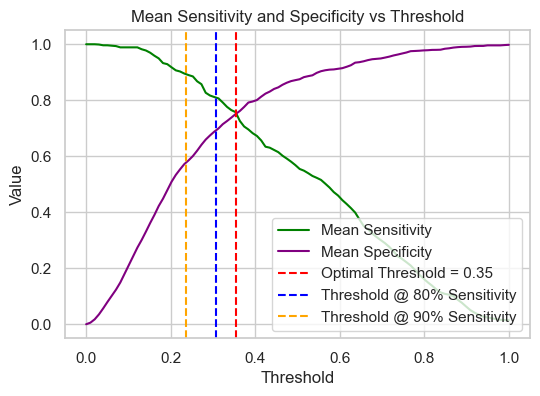

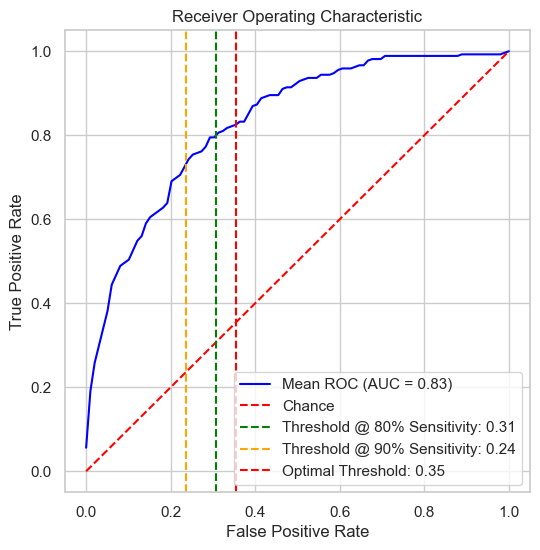

In [11]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a proper random seed, X, y, and other variables
np.random.seed(random_value)

# Define the pipeline
pipelines = {
    'SigmoidModel': Pipeline([
        ('imputer', IterativeImputer(random_state=random_value)),
        ('scaler', RobustScaler()),
        ('classifier', SigmoidModel(
            random_state=random_value, 
            init_type='uniform', 
            learning_rate=0.05, 
            n_epochs=50, 
            penalty='l1', 
            penalty_strength=0.01
        ))
    ])
}

# Select the pipeline to use (in this case, SigmoidModel)
model_pipeline = pipelines['SigmoidModel']

# Initialize variables to store results
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_value)
mean_fpr = np.linspace(0, 1, 100)
mean_thresholds = np.linspace(0, 1, 100)
interpolated_sensitivities = []
interpolated_specificities = []
fprs = []
tprs = []
aucs = []
sens_80_spec = []
sens_90_spec = []
sens_80_threshold = []
sens_90_threshold = []

# Perform cross-validation
fold = 1
for train_index, test_index in cv.split(X, y):
    print(f"Processing fold {fold}")
    X_train_fold, X_val_fold = X[train_index], X[test_index]
    y_train_fold, y_val_fold = y[train_index], y[test_index]

    # Fit the pipeline on the training fold
    model_pipeline.fit(X_train_fold, y_train_fold)

    # Get the predicted probabilities on the validation fold
    y_proba = model_pipeline.predict_proba(X_val_fold)[:, 1]

    # Compute ROC curve and area under the curve for this fold
    fpr, tpr, thresholds = roc_curve(y_val_fold, y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Find the threshold and corresponding specificity for sensitivity (TPR) = 0.80 and 0.90
    idx_80 = np.where(tpr >= 0.80)[0][0]
    idx_90 = np.where(tpr >= 0.90)[0][0]

    sens_80_spec.append(1 - fpr[idx_80])  # Specificity = 1 - FPR
    sens_90_spec.append(1 - fpr[idx_90])

    sens_80_threshold.append(thresholds[idx_80])
    sens_90_threshold.append(thresholds[idx_90])

    # Collect FPR and TPR for ROC curve interpolation
    fprs.append(fpr)
    tprs.append(tpr)

    # Reverse thresholds and corresponding tpr and fpr for interpolation
    thresholds_rev = thresholds[::-1]
    tpr_rev = tpr[::-1]
    fpr_rev = fpr[::-1]
    specificity_rev = 1 - fpr_rev  # Specificity = 1 - FPR

    # Interpolate sensitivity (TPR) and specificity at mean thresholds
    interp_sensitivity = np.interp(mean_thresholds, thresholds_rev, tpr_rev)
    interp_specificity = np.interp(mean_thresholds, thresholds_rev, specificity_rev)

    interpolated_sensitivities.append(interp_sensitivity)
    interpolated_specificities.append(interp_specificity)

    fold += 1

# Compute mean sensitivities and specificities across folds
mean_sensitivities = np.mean(interpolated_sensitivities, axis=0)
mean_specificities = np.mean(interpolated_specificities, axis=0)

# Find the optimal threshold where sensitivity and specificity are closest
sensitivity_specificity_diff = np.abs(mean_sensitivities - mean_specificities)
optimal_index = np.argmin(sensitivity_specificity_diff)
optimal_threshold = mean_thresholds[optimal_index]
optimal_sensitivity = mean_sensitivities[optimal_index]
optimal_specificity = mean_specificities[optimal_index]

# Calculate the average recall thresholds
mean_sens_80_spec = np.mean(sens_80_spec)
mean_sens_90_spec = np.mean(sens_90_spec)

mean_sens_80_threshold = np.mean(sens_80_threshold)
mean_sens_90_threshold = np.mean(sens_90_threshold)

# Output the results
print(f'When Sensitivity = 80%:')
print(f'   Specificity = {mean_sens_80_spec:.2f}, Threshold = {mean_sens_80_threshold:.2f}')

print(f'When Sensitivity = 90%:')
print(f'   Specificity = {mean_sens_90_spec:.2f}, Threshold = {mean_sens_90_threshold:.2f}')

print(f'Optimal Threshold: {optimal_threshold:.2f}')
print(f'Sensitivity at Optimal Threshold: {optimal_sensitivity:.2f}')
print(f'Specificity at Optimal Threshold: {optimal_specificity:.2f}')

# Plot Sensitivity and Specificity vs Threshold
plt.figure(figsize=(6, 4))
plt.plot(mean_thresholds, mean_sensitivities, label='Mean Sensitivity', color='green')
plt.plot(mean_thresholds, mean_specificities, label='Mean Specificity', color='purple')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.axvline(x=mean_sens_80_threshold, color='blue', linestyle='--', label=f'Threshold @ 80% Sensitivity')
plt.axvline(x=mean_sens_90_threshold, color='orange', linestyle='--', label=f'Threshold @ 90% Sensitivity')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Mean Sensitivity and Specificity vs Threshold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Compute mean ROC curve
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fprs, tprs)], axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

# Plot ROC curve and annotate recall thresholds
plt.figure(figsize=(6, 6))
plt.plot(mean_fpr, mean_tpr, color='blue', label='Mean ROC (AUC = %0.2f)' % mean_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Chance')

# Mark the thresholds for 80% and 90% recall
plt.axvline(x=mean_sens_80_threshold, color='green', linestyle='--', label=f'Threshold @ 80% Sensitivity: {mean_sens_80_threshold:.2f}')
plt.axvline(x=mean_sens_90_threshold, color='orange', linestyle='--', label=f'Threshold @ 90% Sensitivity: {mean_sens_90_threshold:.2f}')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Evaluate

In [12]:
np.random.seed(random_value)

model = joblib.load('models/SigmoidModel_penalty.joblib')

y_probs_test = model.predict_proba(X_test)[:, 1]  

custom_threshold = optimal_threshold

y_pred_test_custom = (y_probs_test >= custom_threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred_test_custom)
precision = precision_score(y_test, y_pred_test_custom)
recall = recall_score(y_test, y_pred_test_custom)
f1 = f1_score(y_test, y_pred_test_custom)
roc_auc = roc_auc_score(y_test, y_probs_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test_custom).ravel()
specificity = tn / (tn + fp) 

print(f"Custom Threshold: {custom_threshold}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

print(f"\nConfusion Matrix at threshold {custom_threshold}:")
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")


Custom Threshold: 0.3535353535353536
Accuracy: 0.7759
Precision: 0.6458
Recall (Sensitivity): 0.7750
Specificity: 0.7763
F1 Score: 0.7045
ROC AUC Score: 0.8368

Confusion Matrix at threshold 0.3535353535353536:
TN: 59, FP: 17, FN: 9, TP: 31


# Additional

                    Type       min       max      mean
0             Perceptron  0.515973  2.022322  1.251100
1  Perceptron\n(Penalty)  0.589930  2.283253  1.302335
2                Sigmoid  0.943564  3.215968  1.995873
3     Sigmoid\n(Penalty)  0.928709  3.998268  2.160038


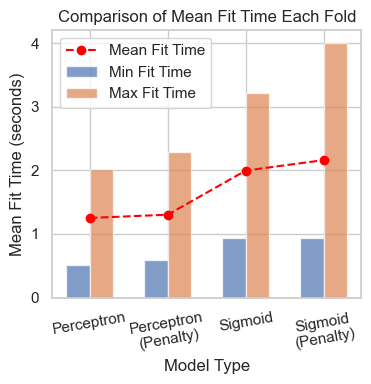

In [164]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the file paths and corresponding type mappings
file_mapping = {
    'results/SigmoidModel_penalty.csv': 'Sigmoid\n(Penalty)',
    'results/SigmoidModel_wo_penalty.csv': 'Sigmoid',
    'results/BasePerceptron_wo_penalty.csv': 'Perceptron',
    'results/BasePerceptron_baseline_results.csv': 'Perceptron',
    'results/BasePerceptron_penalty.csv': 'Perceptron\n(Penalty)',
}

dfs = []
for file, model_type in file_mapping.items():
    df = pd.read_csv(file)  # Replace with the correct file path
    df['Type'] = model_type
    
    # Check if 'mean_fit_time' exists in each CSV
    if 'mean_fit_time' in df.columns:
        dfs.append(df[['mean_fit_time', 'Type']])  # Keep only necessary columns
    else:
        print(f"Column 'mean_fit_time' not found in {file}")

# Concatenate all the dataframes into a single dataframe
combined_df = pd.concat(dfs, ignore_index=True)

# Group by 'Type' and calculate min, max, and mean of 'mean_fit_time'
fit_time_stats = combined_df.groupby('Type')['mean_fit_time'].agg(['min', 'max', 'mean']).reset_index()

print(fit_time_stats)

# Plotting the results with separate bars for min and max, and mean as a line
plt.figure(figsize=(4,4))

# Plotting min and max as separate bars
bar_width = 0.3
index = range(len(fit_time_stats))

plt.bar(index, fit_time_stats['min'], bar_width, label='Min Fit Time', alpha=0.7)
plt.bar([i + bar_width for i in index], fit_time_stats['max'], bar_width, label='Max Fit Time', alpha=0.7)

# Plotting the mean as a red line with dots
plt.plot([i + bar_width / 2 for i in index], fit_time_stats['mean'], color='red', marker='o', linestyle='--', label='Mean Fit Time')

# Customizing the chart
plt.xlabel('Model Type')
plt.ylabel('Mean Fit Time (seconds)')
plt.title('Comparison of Mean Fit Time Each Fold')
plt.xticks([i + bar_width / 2 for i in index], fit_time_stats['Type'], rotation=10)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

                    Type       min       max      mean  \
0             Perceptron  0.515973  2.022322  1.251100   
1  Perceptron\n(Penalty)  0.589930  2.283253  1.302335   
2                Sigmoid  0.943564  3.215968  1.995873   
3     Sigmoid\n(Penalty)  0.928709  3.998268  2.160038   

   min_percentage_increase  max_percentage_increase  mean_percentage_increase  
0                 0.000000                 0.000000                  0.000000  
1                14.333478                12.902556                  4.095221  
2                82.870751                59.023541                 59.529547  
3                79.991714                97.706748                 72.651165  


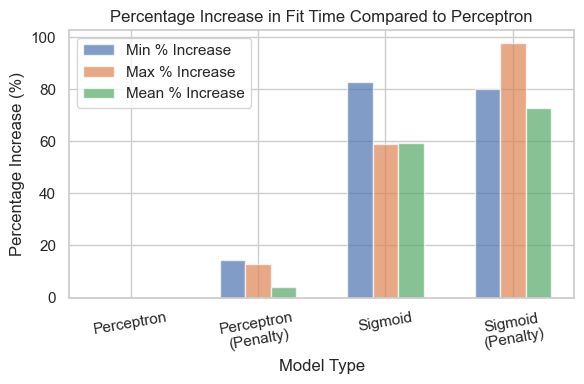

In [161]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the file paths and corresponding type mappings
file_mapping = {
    'results/SigmoidModel_penalty.csv': 'Sigmoid\n(Penalty)',
    'results/SigmoidModel_wo_penalty.csv': 'Sigmoid',
    'results/BasePerceptron_wo_penalty.csv': 'Perceptron',
    'results/BasePerceptron_baseline_results.csv': 'Perceptron',
    'results/BasePerceptron_penalty.csv': 'Perceptron\n(Penalty)',
}

# Load the CSV files and assign the corresponding model types
dfs = []
for file, model_type in file_mapping.items():
    df = pd.read_csv(file)  # Replace with the correct file path
    df['Type'] = model_type
    
    # Check if 'mean_fit_time' exists in each CSV
    if 'mean_fit_time' in df.columns:
        dfs.append(df[['mean_fit_time', 'Type']])  # Keep only necessary columns
    else:
        print(f"Column 'mean_fit_time' not found in {file}")

# Concatenate all dataframes
combined_df = pd.concat(dfs, ignore_index=True)

# Group by 'Type' and calculate min, max, and mean of 'mean_fit_time'
fit_time_stats = combined_df.groupby('Type')['mean_fit_time'].agg(['min', 'max', 'mean']).reset_index()

# Extract 'Perceptron' values as the base
base_perceptron_stats = fit_time_stats[fit_time_stats['Type'] == 'Perceptron'].iloc[0]

# Calculate the percentage increase for each metric (min, max, mean) relative to Perceptron
fit_time_stats['min_percentage_increase'] = ((fit_time_stats['min'] - base_perceptron_stats['min']) / base_perceptron_stats['min']) * 100
fit_time_stats['max_percentage_increase'] = ((fit_time_stats['max'] - base_perceptron_stats['max']) / base_perceptron_stats['max']) * 100
fit_time_stats['mean_percentage_increase'] = ((fit_time_stats['mean'] - base_perceptron_stats['mean']) / base_perceptron_stats['mean']) * 100

# Print the updated statistics with percentage increase
print(fit_time_stats)

# Plotting the percentage increase for min, max, and mean
plt.figure(figsize=(6,4))

bar_width = 0.2
index = range(len(fit_time_stats))

# Plot min, max, and mean percentage increases
plt.bar(index, fit_time_stats['min_percentage_increase'], bar_width, label='Min % Increase', alpha=0.7)
plt.bar([i + bar_width for i in index], fit_time_stats['max_percentage_increase'], bar_width, label='Max % Increase', alpha=0.7)
plt.bar([i + bar_width * 2 for i in index], fit_time_stats['mean_percentage_increase'], bar_width, label='Mean % Increase', alpha=0.7)

# Customizing the chart
plt.xlabel('Model Type')
plt.ylabel('Percentage Increase (%)')
plt.title('Percentage Increase in Fit Time Compared to Perceptron')
plt.xticks([i + bar_width for i in index], fit_time_stats['Type'], rotation=10)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


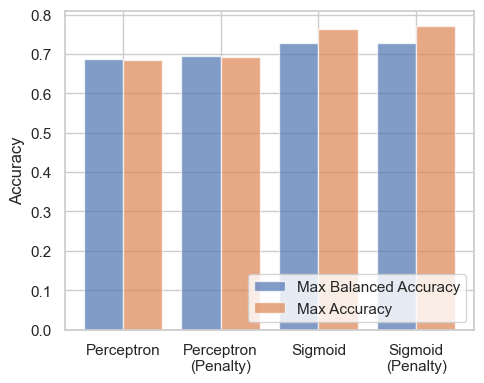

In [172]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the file paths and corresponding type mappings
file_mapping = {
    'results/SigmoidModel_penalty.csv': 'Sigmoid\n(Penalty)',
    'results/SigmoidModel_wo_penalty.csv': 'Sigmoid',
    'results/BasePerceptron_wo_penalty.csv': 'Perceptron',
    'results/BasePerceptron_baseline_results.csv': 'Perceptron',
    'results/BasePerceptron_penalty.csv': 'Perceptron\n(Penalty)',
}

# Load the CSV files and assign the corresponding model types
dfs = []
for file, model_type in file_mapping.items():
    df = pd.read_csv(file)  # Replace with the correct file path
    df['Type'] = model_type
    
    # Check if 'mean_test_balanced_accuracy' and 'mean_test_accuracy' exist in each CSV
    if 'mean_test_balanced_accuracy' in df.columns and 'mean_test_accuracy' in df.columns:
        dfs.append(df[['mean_test_balanced_accuracy', 'mean_test_accuracy', 'Type']])  # Keep only necessary columns
    else:
        print(f"Required columns not found in {file}")

# Concatenate all dataframes
combined_df = pd.concat(dfs, ignore_index=True)

# Group by 'Type' and calculate the maximum of 'mean_test_balanced_accuracy' and 'mean_test_accuracy'
accuracy_stats = combined_df.groupby('Type').agg({
    'mean_test_balanced_accuracy': 'max',
    'mean_test_accuracy': 'max'
}).reset_index()

# Plotting the comparison of mean_test_balanced_accuracy and mean_test_accuracy
plt.figure(figsize=(5,4))

bar_width = 0.4
index = range(len(accuracy_stats))

# Bar plot for mean_test_balanced_accuracy
plt.bar(index, accuracy_stats['mean_test_balanced_accuracy'], bar_width, label='Max Balanced Accuracy', alpha=0.7)

# Bar plot for mean_test_accuracy shifted by bar_width
plt.bar([i + bar_width for i in index], accuracy_stats['mean_test_accuracy'], bar_width, label='Max Accuracy', alpha=0.7)

# Customizing the chart
plt.xlabel('')
plt.ylabel('Accuracy')
plt.title('')
plt.xticks([i + bar_width / 2 for i in index], accuracy_stats['Type'], rotation=0)

# Move the legend to the bottom right
plt.legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()
